In [4]:
import os
import numpy as np
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

class Mouse:
    """
    A class representing a mouse with access to the Allen Brain Observatory data.
    """
    
    __drive_path = os.path.dirname(os.getcwd()) 
    __manifest_file = os.path.join(__drive_path, 'BrainObservatoryCache', 'manifest.json')
    __boc = BrainObservatoryCache(manifest_file=__manifest_file)
    
    
    def __init__(self, ec_id):
        """
        Initialize a Mouse instance with the given experiment container id (ec_id).
        """ 
        self.experiment_container = Mouse.__boc.get_experiment_containers(ids=[ec_id])[0]
        self._get_data_set(ec_id)
        self._get_dff()
        self._N_distance_sampling()

        
        file_dir = os.path.join(__drive_path, "Instances", "Mouse_" + str(ec_id) + ".pickle")

        # Save the instance to a file using pickle   
        if not os.path.exists(file_dir):
            with open(file_dir, "wb") as file:
                pickle.dump(self, file) 
        else:
            

    def __str__(self):
        self.name = "Mouse_" + str(self.experiment_container['id']) + "_" + self.experiment_container['targeted_structure'] + "_" + str(self.experiment_container['imaging_depth'])
        return self.name
    
    def _get_data_set(self, ec_id):
        """
        Retrieve and process the data set for the given experiment container ID.
        """
        boc = Mouse.__boc
        experiments_dict = boc.get_ophys_experiments(experiment_container_ids=[ec_id])
        keys_to_select = ['id', 'acquisition_age_days', 'session_type']

        self.experiments_dict = [
            {key: experiment[key] for key in keys_to_select} 
            for experiment in experiments_dict
        ]
        
        for experiment in self.experiments_dict:
            experiment['experiment_stimuli'] = boc.get_ophys_experiment_stimuli(experiment['id'])

        self.experiments_dict.sort(key=lambda x: x['acquisition_age_days'])
        
        self.data_sets = [
            boc.get_ophys_experiment_data(ophys_experiment_id=experiment['id'])
            for experiment in self.experiments_dict
        ]

        # self._events = [
        #     boc.get_ophys_experiment_events(ophys_experiment_id=experiment['id'])
        #     for experiment in self.experiments_dict
        # ]
        
    def _get_dff(self):
            DFF = np.zeros([len(self.mutal_cell_ids()), len(self.data_sets), 10, 900])

            for index, data_set in enumerate(self.data_sets):
                ts, dff = data_set.get_dff_traces()
                dff = dff[data_set.get_cell_specimen_indices(self.mutal_cell_ids()), :]

                natural_movie_one_table = data_set.get_stimulus_table('natural_movie_one')
                table = []
                for i in range(10):
                    repeat_i = natural_movie_one_table[natural_movie_one_table['repeat'] == i]
                    table.append( {'repeat' : i + 1, 'start' : repeat_i.start.to_list()[0] , 'end' : repeat_i.end.to_list()[-1] } )
                natural_movie_one_table = table

                temp = np.zeros([dff.shape[0], 10, 900])

                for i in range(10):
                    start = table[i]['start']
                    end = start + 900

                    temp[:, i, :] = dff[:, start:end]

                dff = temp

                DFF[:, index, :, :] = dff

            self.dff = DFF
   
    def _N_distance_sampling(self):
        N = len(self.mutal_cell_ids())

        average_distances = []
        n_array = []
        n = 2

        while n < 2*N:
            if n > N:
                n = N

            temp = []
            for repeat in range(100):
                temp.append(self.average_distances_to_references(n))

            average_distances.append(np.array(temp).mean(axis=0))

            n_array.append(n)
            n = n*2

        average_distances = np.array(average_distances)
        
        self.N_distance_sampling = (n_array, average_distances)
        
    def mutal_cell_ids(self):
        cell_ids = set(self.data_sets[0].get_cell_specimen_ids())
        
        for data_set in self.data_sets:
            cell_ids = cell_ids.intersection(data_set.get_cell_specimen_ids())
        
        return list(cell_ids)
    
    def average_distances_to_references(self, n="Not Given"):
        
        if n == "Not Given":
            n = len(self.mutal_cell_ids())
            
        DFFs = self.dff # dimensions (neuron, session, trial, frame)

        # Reshaping all 3 sessions with 10 trials into 30 trials together 
        Nneurons, Nsessions, Ntrials, Nframse = DFFs.shape 
        # DFFs = np.reshape(DFFs, (Nneurons, Nsessions*Ntrials, Nframse))

        # Selecting n neurons out of Nneurons
        rnd_selected_neurons  = np.random.choice(Nneurons, size=n, replace=False)
        DFFs = DFFs[rnd_selected_neurons, :]


        references = DFFs.mean(axis=2)

        average_distance_to_refrences = []
        for session in range(3):
            temp = []
            for trial in range(10):
                distance_vector = np.linalg.norm(DFFs[:, session, trial, :] - references[:, session, :], axis=0)
                temp.append((distance_vector*distance_vector).mean())
            average_distance_to_refrences.append(np.array(temp))

        return np.array(average_distance_to_refrences).mean(axis=1)

    def get_correlation_matrix(self):
       
        if self.corr_matrix is None:
            data = self.get_dff()
            Nneurons, Nsessions, Ntrials, Nframes = data.shape
            data = np.reshape(data, (data.shape[0], -1))

            corr_matrix = -squareform(pdist(data.T, 'correlation')) + 1
            corr_matrix[np.isnan(corr_matrix)] = 0

            self.corr_matrix = corr_matrix
            
        return self.corr_matrix
    
    def distance(signals):
        Nneurons, Ntrials, Nframes = signals.shape
        
        distances = {}
        
        for t1 in range(Ntrials):
            for t2 in np.arange(t1+1, Ntrials):
                d = signals[:, t1, :] - signals[:, t2, :]
                d = np.linalg.norm(d.mean(axis = 1))
                distances[(t1, t2)] = d
        
        within_session = {}
        for session in range(3):
            temp = []
            for t1 in np.arange(10) + session*10:
                for t2 in np.arange(t1+1, session*10+10):
                    temp.append(distances[(t1, t2)])
                    del distances[(t1, t2)] 
            within_session["Session " + str(session+1)] = np.array(temp)
        
        
        return within_session, distances
    
    def get_events(self, stimulus_name):
        DFF = np.zeros([len(self.mutal_cell_ids()), len(list(self.data_sets.values())), 10, 900])
        
        for index, data_set in enumerate(list(self.data_sets.values())):
            ts, dff = data_set.get_dff_traces()
            dff = dff[data_set.get_cell_specimen_indices(self.mutal_cell_ids()), :]
            natural_movie_one_table = data_set.get_stimulus_table('natural_movie_one')
            table = []
            for i in range(10):
                repeat_i = natural_movie_one_table[natural_movie_one_table['repeat'] == i]
                table.append( {'repeat' : i + 1, 'start' : repeat_i.start.to_list()[0] , 'end' : repeat_i.end.to_list()[-1] } )
            natural_movie_one_table = table

            temp = np.zeros([dff.shape[0], 10, 900])

            for i in range(10):
                start = table[i]['start']
                end = start + 900

                temp[:, i, :] = dff[:, start:end]

            dff = temp
            
            DFF[:, index, :, :] = dff
            
            return DFF
    
    def get_stimulus_dff(self, stimulus_name = 'natural_movie_one'):
        data_sets = self.data_sets.keys()
        
        self.data_sets
        natural_movie_one_table = data_set.get_stimulus_table(stimulus_name)
        
        table = []
        for i in range(10):
            repeat_i = natural_movie_one_table[natural_movie_one_table['repeat'] == i]
            table.append( {'repeat' : i + 1, 'start' : repeat_i.start.to_list()[0] , 'end' : repeat_i.end.to_list()[-1] } )

        natural_movie_one_table = table

        temp = np.zeros([dff.shape[0], 900, 10])

        for i in range(10):
            start = table[i]['start']
            end = start + 900

            temp[:, :, i] = dff[:, start:end]

        dff = temp

#     def get_corr_matrix_hist(self):
#         corr_matrix = mouse.get_correlation_matrix()
#         PV_corrs = corr_matrix[np.triu(corr_matrix) == corr_matrix]
#         print(PV_corrs.shape)
#         plt.hist(PV_corrs, bins=300, density=True)
#         plt.title("Histogram of PV correlations for 3 sessions each 10 repeats\n")
#         plt.xlabel("PV correlation")
#         plt.ylabel("Counts")
        
#         plt.show()
#         return 

# mouse = Mouse(ec_id=637669268)
# mouse = Mouse(ec_id=652842570)

In [5]:
""" This code gets all the mice with specific experiments and saves them as instances of class Mouse """


# Properties of the experiments 
exp_container = pd.DataFrame(Mouse._Mouse__boc.get_ophys_experiments(stimuli=['natural_movie_one'], targeted_structures=['VISp']))


# Related experiment container ids
ids = exp_container['experiment_container_id'].tolist()


# replacing all the int values in dataframe with string type to use them as filenames while saving in computer 
exp_container['imaging_depth'] = exp_container['imaging_depth'].astype(str)
exp_container['experiment_container_id'] = exp_container['experiment_container_id'].astype(str)


# Making names for the mice instances files
file_names = exp_container.apply(lambda row: '_'.join(row[['experiment_container_id', 'targeted_structure','imaging_depth']]), axis=1).tolist()


# Directory to store instances 
import pickle 
parent_dir = os.path.dirname(os.getcwd())


# For loop to create instances and saving them with their specific name
for index in range(len(ids)):
    
    file_dir = os.path.join(parent_dir, "Instances", "Mouse_" + file_names[index] + ".pickle")
    print(index, end='\r')
    
    # Save the instance to a file using pickle   
    if not os.path.exists(file_dir):
        mouse_obj = Mouse(ec_id=ids[index])
        with open(file_dir, "wb") as file:
            pickle.dump(mouse_obj, file)
    
        print("Created " + str(index+1), end='\r')

In [6]:
# Load the instances from the file
parent_dir = os.path.dirname(os.getcwd())
mouses = []
for index in range(len(ids)):
    file_dir = os.path.join(parent_dir, "Instances", "Mouse_" + file_names[index] + ".pickle")

    with open(file_dir, "rb") as file:
        mouses.append(pickle.load(file))

In [8]:
exponents = []
d1 = []
time = []

for mouse in mouses:
    N, d = mouse.N_distance_sampling
    
    if len(N) > 2:
        slopes, intercepts = np.polyfit(np.log(N), np.log(np.sqrt(d)), deg=1)
        exponents.append(slopes)
        d1.append(np.exp(intercepts))

        days = np.array(pd.DataFrame(mouse.experiments_dict)['acquisition_age_days'].tolist())
        days = days - days[0]
        time.append(days)
    

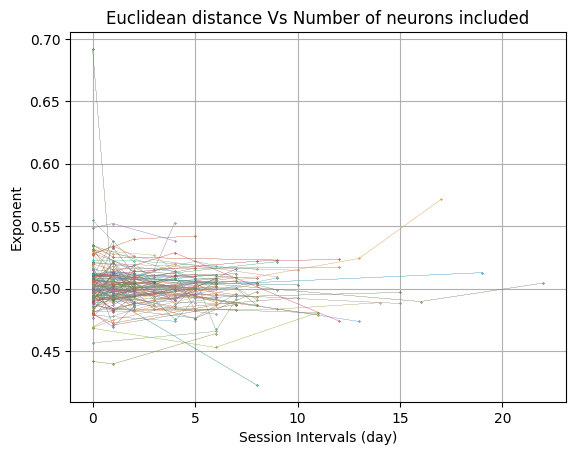

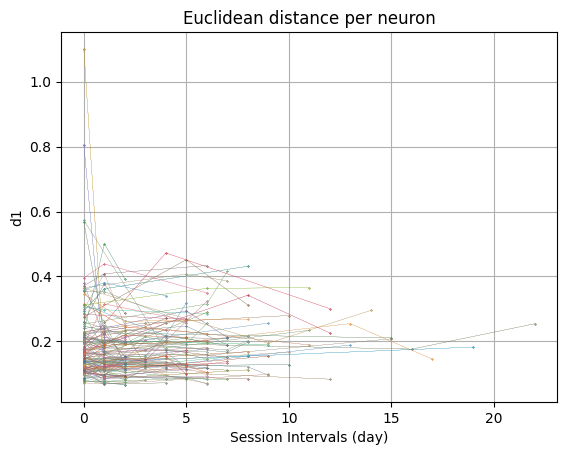

In [6]:
for i in range(len(time)):
    plt.plot(time[i], exponents[i], '.-', linewidth=0.1, markersize=0.5)

plt.xlabel("Session Intervals (day)")
plt.title("Euclidean distance Vs Number of neurons included")
plt.ylabel("Exponent")
plt.grid('minor')
# plt.savefig("Euclidean distance Vs Number of neurons included.png")
plt.show()

for i in range(len(time)):
    plt.plot(time[i], d1[i], '.-', linewidth=0.1, markersize=0.5)

plt.xlabel("Session Intervals (day)")
plt.title("Euclidean distance per neuron")
plt.ylabel("d1")
plt.grid('minor')
# plt.savefig("Euclidean distance per neuron.png")
plt.show()


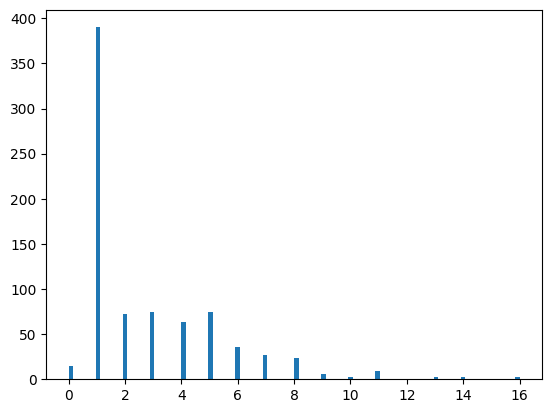

In [70]:
plt.hist(np.diff(time).flatten(), bins=100)
plt.show()

In [ ]:
plt.hist(time)

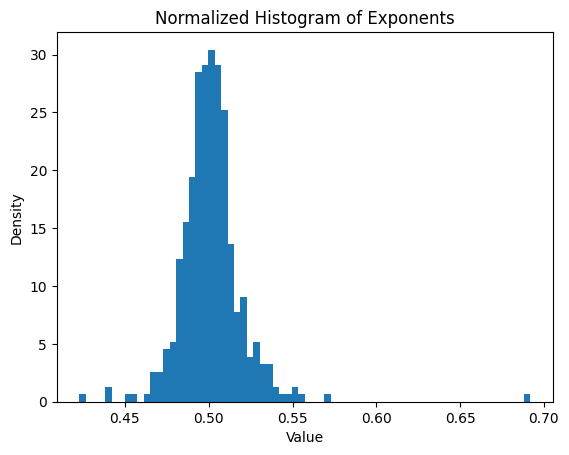

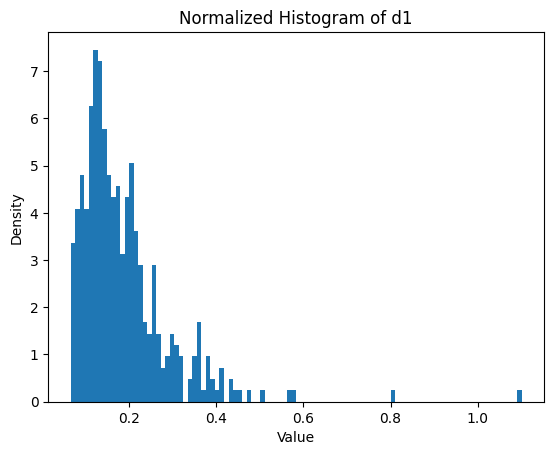

In [29]:
plt.hist(np.array(exponents).flatten(), bins = 70, density=True)
plt.title('Normalized Histogram of Exponents')
plt.xlabel('Value')
plt.ylabel('Density')
# plt.savefig('Normalized Histogram of Exponents.png')
plt.show()

plt.hist(np.array(d1).flatten(), bins = 100, density=True)
plt.title('Normalized Histogram of d1')
plt.xlabel('Value')
plt.ylabel('Density')
# plt.savefig('Normalized Histogram of d1.png')
plt.show()

/var/folders/wg/0phn_xdj13l7g8nh_5cwybn00000gp/T/ipykernel_23882/3168175455.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Statistics of N dependency of Euclidean distance")
/var/folders/wg/0phn_xdj13l7g8nh_5cwybn00000gp/T/ipykernel_23882/3168175455.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Statistics of N dependency of Euclidean distance")
/var/folders/wg/0phn_xdj13l7g8nh_5cwybn00000gp/T/ipykernel_23882/3168175455.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Statistics of N dependency of Euclidean distance")
/var/folders/wg/0phn_xdj13l7g8nh

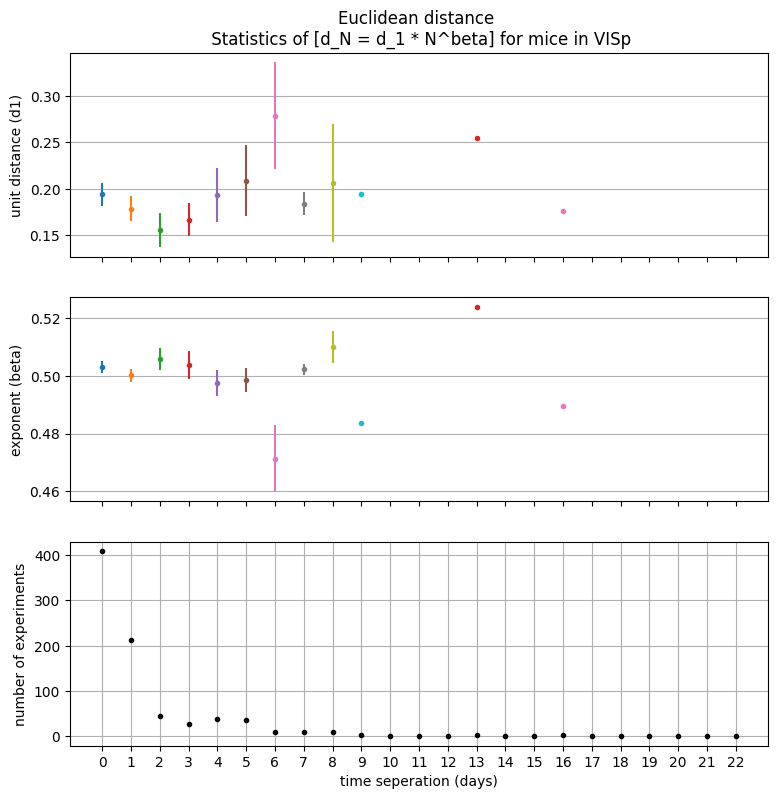

In [28]:
# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

    ###############################################################
data = {day: [] for day in range(23)}
for i in range(len(d1)):
    for session in [0, 1]:
        data[time[i][session]].append(d1[i][session])

mean_std_error = []
mean = []

for key in data.keys():
    mean.append(np.mean(data[key]))
    mean_std_error.append(1.96*np.std(data[key])/np.sqrt(len(data[key])))

for i in range(len(mean)):
    ax1.errorbar(i, mean[i], mean_std_error[i], mean_std_error[i], '.')

    ################################################################
data = {day: [] for day in range(23)}
for i in range(len(exponents)):
    for session in [0, 1]:
        data[time[i][session]].append(exponents[i][session])

mean_std_error = []
mean = []

for key in data.keys():
    mean.append(np.mean(data[key]))
    mean_std_error.append(1.96*np.std(data[key])/np.sqrt(len(data[key])))
    
for i in range(len(list(data.values()))):
    ax2.errorbar(i, mean[i], mean_std_error[i], mean_std_error[i], '.')

    
    
    #################################################################
for i in range(len(list(data.values()))):
    ax3.plot(list(data.keys())[i], len(list(data.values())[i]), 'k.')

# Customize the subplots
ax1.set_ylabel('unit distance (d1)')
ax2.set_ylabel('exponent (beta)')
ax3.set_ylabel('number of experiments')
ax3.set_xlabel('time seperation (days)')
ax3.set_xticks(np.arange(23))

ax1.grid(axis='y')
ax2.grid(axis='y')
ax3.grid(True)


ax1.set_title("Euclidean distance \n Statistics of [d_N = d_1 * N^beta] for mice in VISp")

plt.savefig("Statistics of N dependency of Euclidean distance")
plt.show()

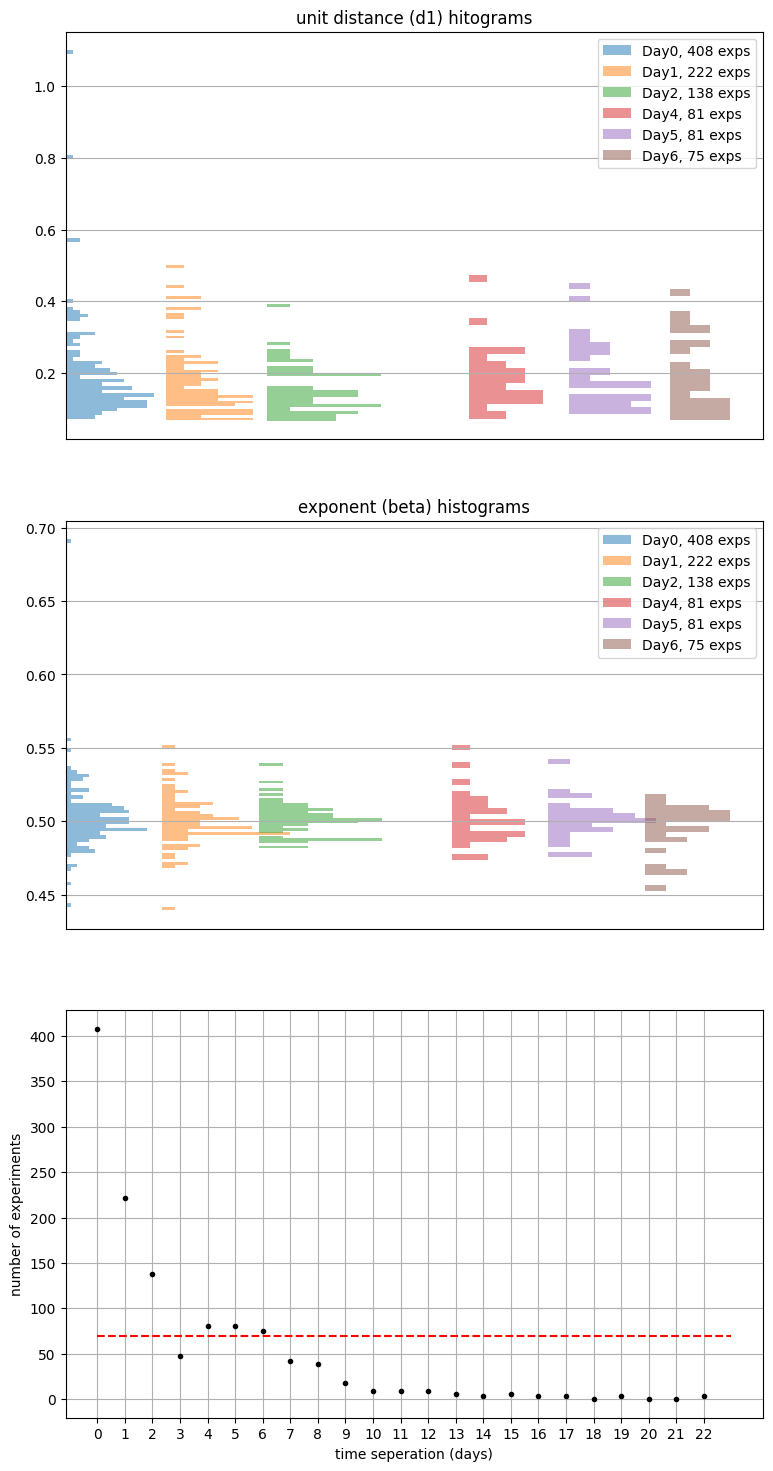

In [130]:
# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(9, 18))

threshold = 70

    ###############################################################
data = {day: [] for day in range(23)}
for i in range(len(d1)):
    for session in range(3):
        data[time[i][session]].append(d1[i][session])

for i in range(len(list(data.values()))):
    if len(data[i]) > threshold:
        ax1.hist(data[i], bins= int(len(data[i])/4) , orientation='horizontal', alpha=0.5, label='Day' + str(i) + ', ' + str(len(data[i])) + ' exps', bottom=i*10, density=True)

ax1.legend()
    ################################################################
data = {day: [] for day in range(23)}
for i in range(len(exponents)):
    for session in range(3):
        data[time[i][session]].append(exponents[i][session])

for i in range(len(list(data.values()))):
    if len(data[i]) > threshold:
        ax2.hist(data[i], bins= int(len(data[i])/4), orientation='horizontal', alpha=0.5, label='Day' + str(i) + ', ' + str(len(data[i])) + ' exps', bottom=i*50, density=True)

ax2.legend()
    #################################################################
for i in range(len(list(data.values()))):
    ax3.plot(list(data.keys())[i], len(list(data.values())[i]), 'k.')

ax3.hlines(y=threshold, xmin=0, xmax=23, colors='r', linestyles='--')

# Customize the subplots
ax1.set_title('unit distance (d1) hitograms')
ax2.set_title('exponent (beta) histograms')
ax3.set_ylabel('number of experiments')
ax3.set_xlabel('time seperation (days)')
ax3.set_xticks(np.arange(23))

ax2.set_xticks([])
ax1.set_xticks([])

ax1.grid(axis='y')
ax2.grid(axis='y')
ax3.grid(True)


plt.savefig("Statistics of N dependency of Euclidean distance (2)")
plt.show()

In [17]:
from scipy.stats import ttest_ind
threshold = 70

data = {day: [] for day in range(23)}
for i in range(len(exponents)):
    for session in range(3):
        data[time[i][session]].append(exponents[i][session])
        
for i in range(23):
    for j in range(23):
        if np.logical_and(len(data[i]) > threshold, len(data[j]) > threshold): 
            print(i, j, ttest_ind(data[i], data[j]))

0 0 Ttest_indResult(statistic=0.0, pvalue=1.0)
0 1 Ttest_indResult(statistic=1.4484155607713034, pvalue=0.1479999483627824)
0 2 Ttest_indResult(statistic=0.6285822420381063, pvalue=0.5298864133405965)
0 4 Ttest_indResult(statistic=0.2568361224563762, pvalue=0.7974137532340644)
0 5 Ttest_indResult(statistic=0.5943782692380695, pvalue=0.5525351572972337)
0 6 Ttest_indResult(statistic=2.9810034655965585, pvalue=0.0030186567337540287)
1 0 Ttest_indResult(statistic=-1.4484155607713034, pvalue=0.1479999483627824)
1 1 Ttest_indResult(statistic=0.0, pvalue=1.0)
1 2 Ttest_indResult(statistic=-0.7636557522575402, pvalue=0.44557538579989997)
1 4 Ttest_indResult(statistic=-0.8235208806531015, pvalue=0.4108638528834003)
1 5 Ttest_indResult(statistic=-0.465637609976734, pvalue=0.6418116526906088)
1 6 Ttest_indResult(statistic=2.5039566659465775, pvalue=0.012821220876344002)
2 0 Ttest_indResult(statistic=-0.6285822420381063, pvalue=0.5298864133405965)
2 1 Ttest_indResult(statistic=0.7636557522575402,

In [16]:
ttest_ind(data[3], data[4])

Ttest_indResult(statistic=-0.18837045297887192, pvalue=0.8508869262493931)

In [22]:
mouses[12].experiments_dict

[{'id': 538803517,
  'acquisition_age_days': 78,
  'session_type': 'three_session_B',
  'experiment_stimuli': ['static_gratings',
   'natural_scenes',
   'natural_movie_one',
   'spontaneous']},
 {'id': 539000397,
  'acquisition_age_days': 79,
  'session_type': 'three_session_C',
  'experiment_stimuli': ['locally_sparse_noise',
   'natural_movie_one',
   'natural_movie_two',
   'spontaneous']},
 {'id': 539290504,
  'acquisition_age_days': 82,
  'session_type': 'three_session_A',
  'experiment_stimuli': ['drifting_gratings',
   'natural_movie_one',
   'natural_movie_three',
   'spontaneous']}]